In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd


import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import sys
sys.path.insert(0,'../../../purity-monitor/')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [4]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [5]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_30V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_30V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20

Single pe = 24.513438823867254


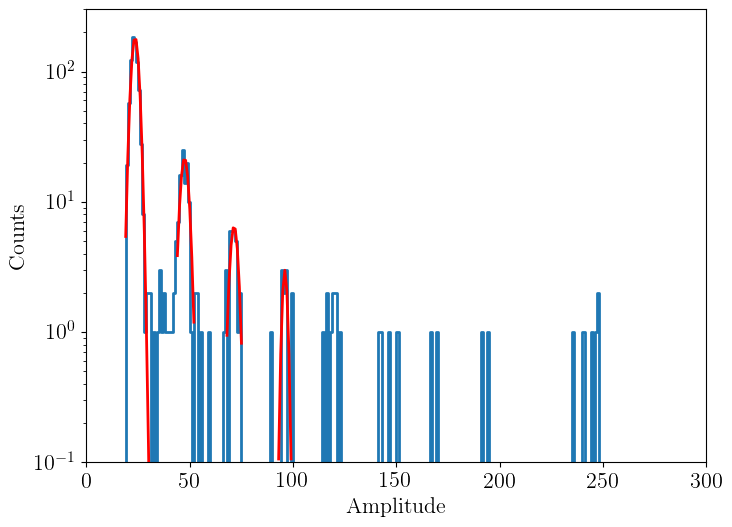

mean_gain 23.99999999998947
sd_gain= 0.36772957745697665


In [6]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,5):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+(7/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

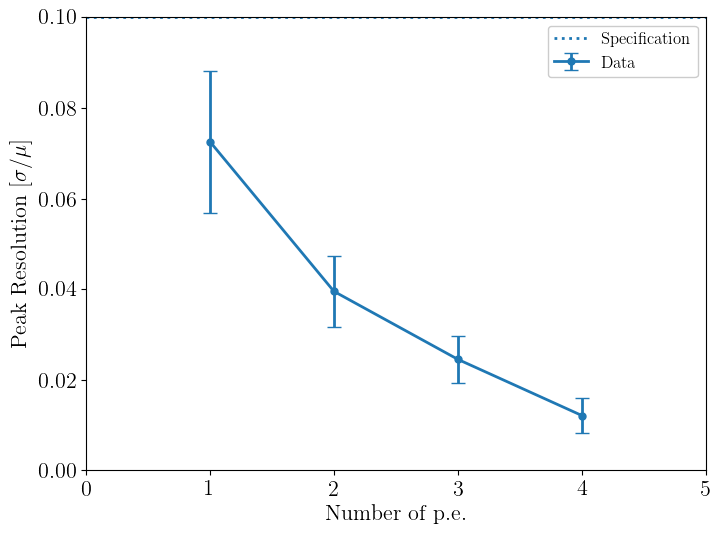

In [7]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [8]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_31V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20

Single pe = 34.85655451719201


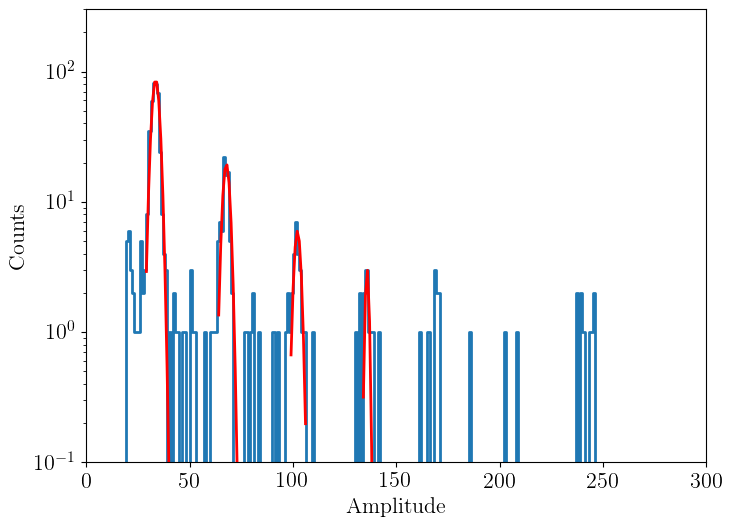

mean_gain 33.95790859469808
sd_gain= 0.36529976579170836


In [9]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,5):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+(7/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

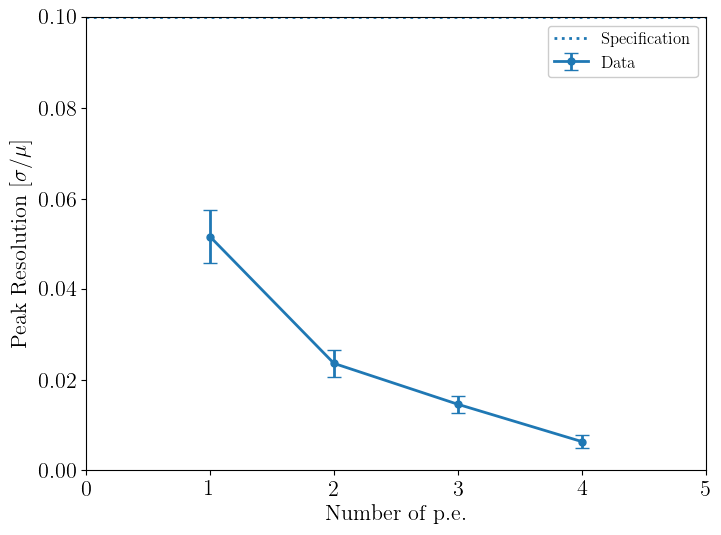

In [10]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [11]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_31.5V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_31.5V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL11

Single pe = 40.238196208874854


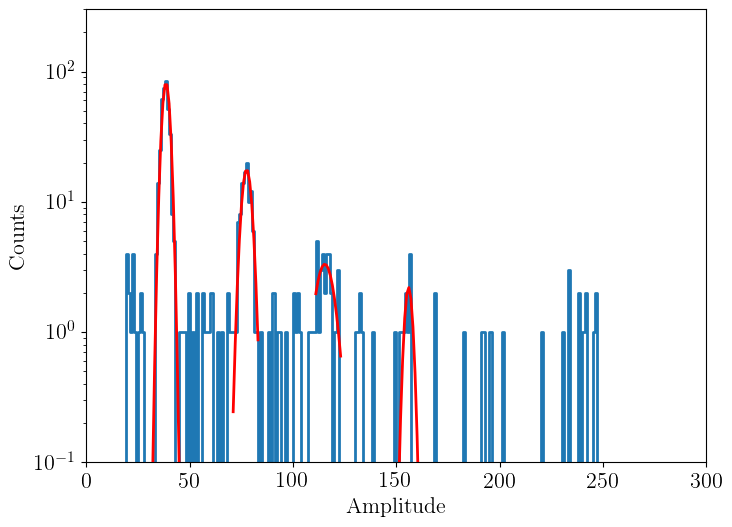

mean_gain 38.968538877833055
sd_gain= 1.001033571794948


In [14]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,5):
    cut = np.where((hx[:-1]>pe*i-10) & (hx[:-1]<pe*i+(7/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

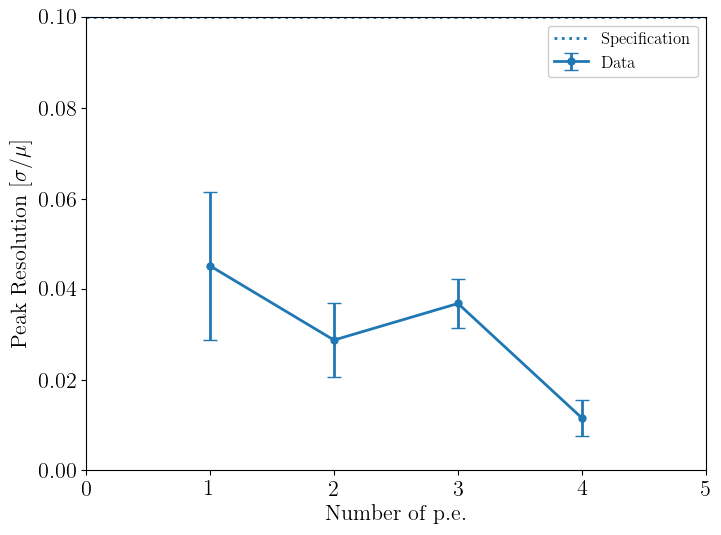

In [15]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [16]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_32V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20

Single pe = 45.31461549897929


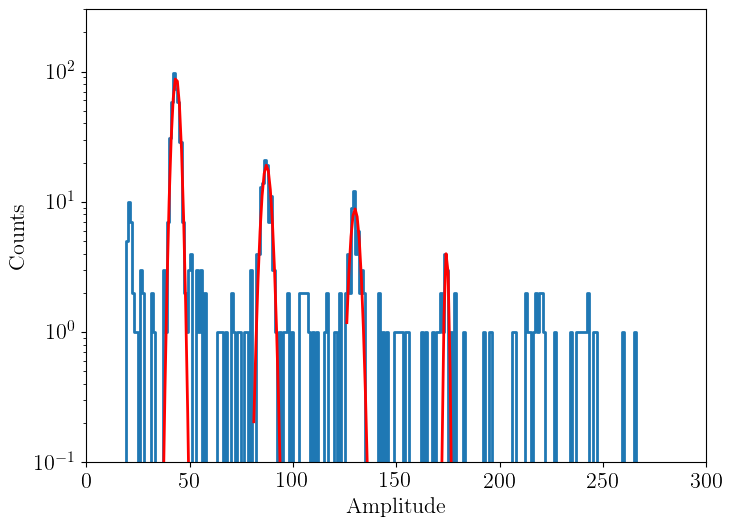

mean_gain 43.56789489134101
sd_gain= 0.5304181719484488


In [17]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,5):
    cut = np.where((hx[:-1]>pe*i-10) & (hx[:-1]<pe*i+(7/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

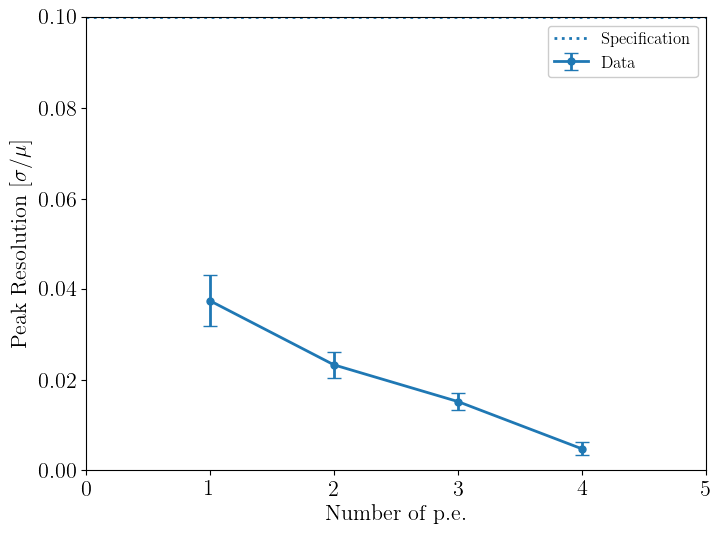

In [18]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [19]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_32.5V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_32.5V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL11

Single pe = 50.11534090341986


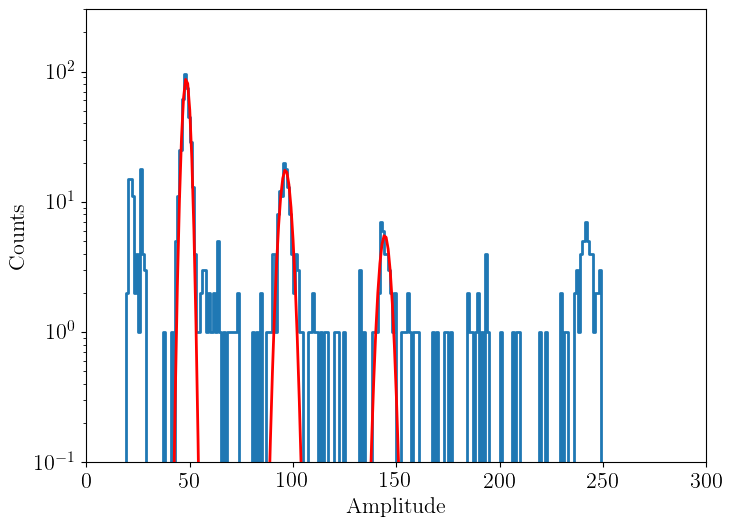

mean_gain 48.11718528551635
sd_gain= 0.14515692561132684


In [25]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,4):
    cut = np.where((hx[:-1]>pe*i-15) & (hx[:-1]<pe*i+(10)))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

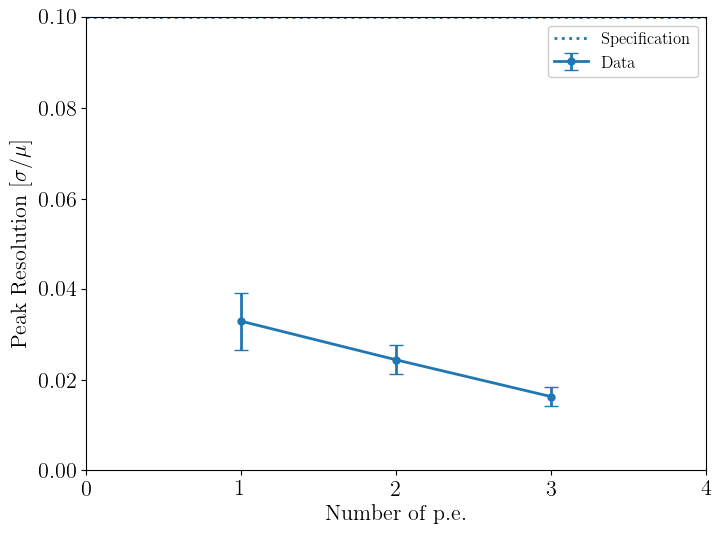

In [26]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [27]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_33V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

9
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_33V_8.h5
Getting data...


Single pe = 55.056459522209536


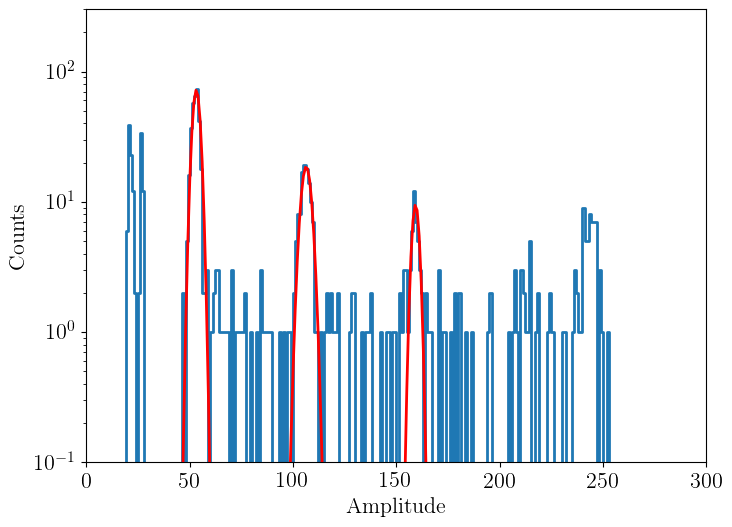

mean_gain 53.085388725045924
sd_gain= 0.12704354307185525


In [28]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,4):
    cut = np.where((hx[:-1]>pe*i-15) & (hx[:-1]<pe*i+(10)))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

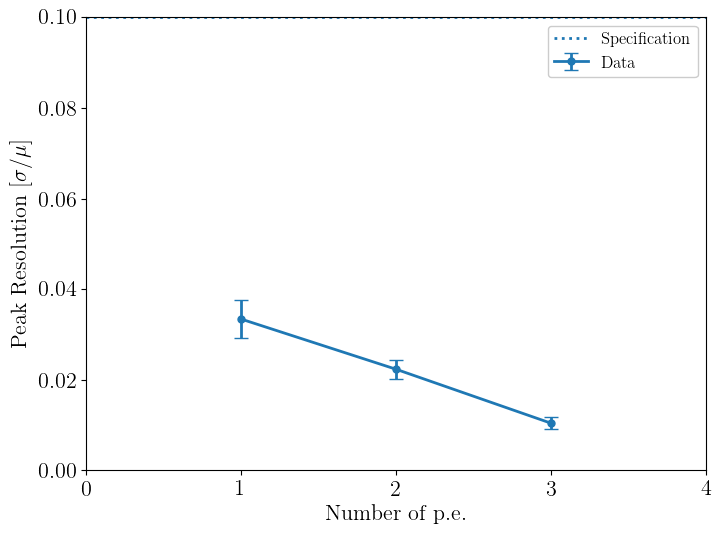

In [29]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [30]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_34V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

15
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_34V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20

Single pe = 64.08169013652139


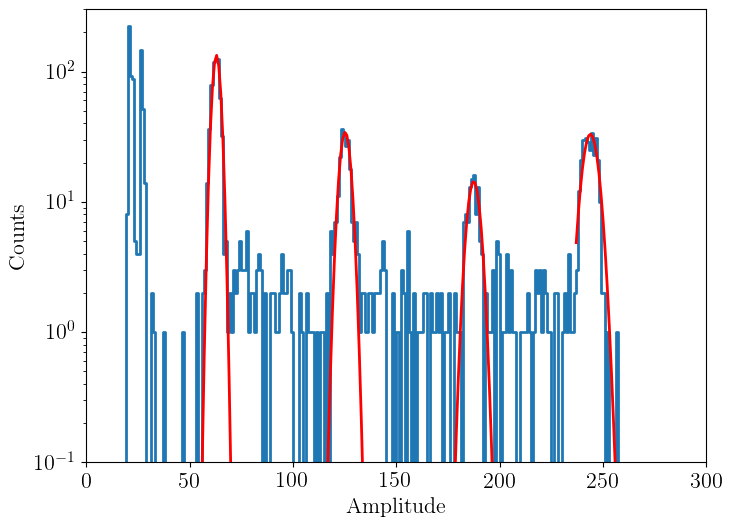

mean_gain 60.96707905979493
sd_gain= 2.6043927065345156


In [33]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,5):
    cut = np.where((hx[:-1]>pe*i-20) & (hx[:-1]<pe*i+(10)))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

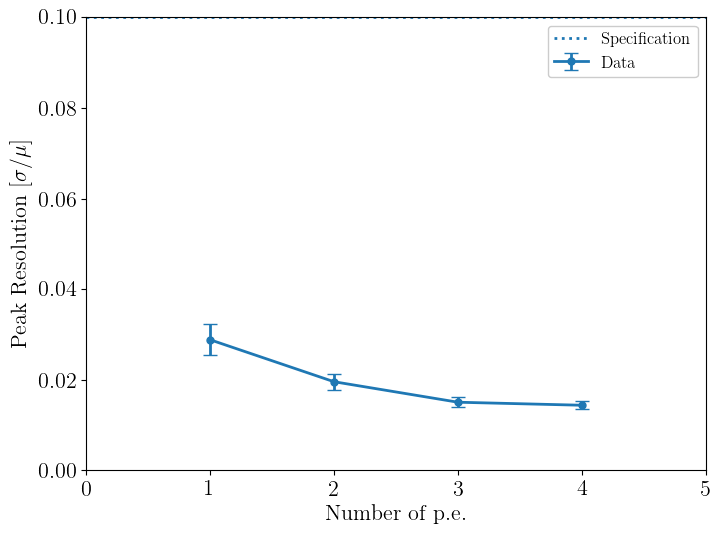

In [34]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [35]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/', 
                    Selection='*DCR_35V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

10
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211129/GXe_SiPM_DCR_35V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20

Single pe = 69.79662852428388


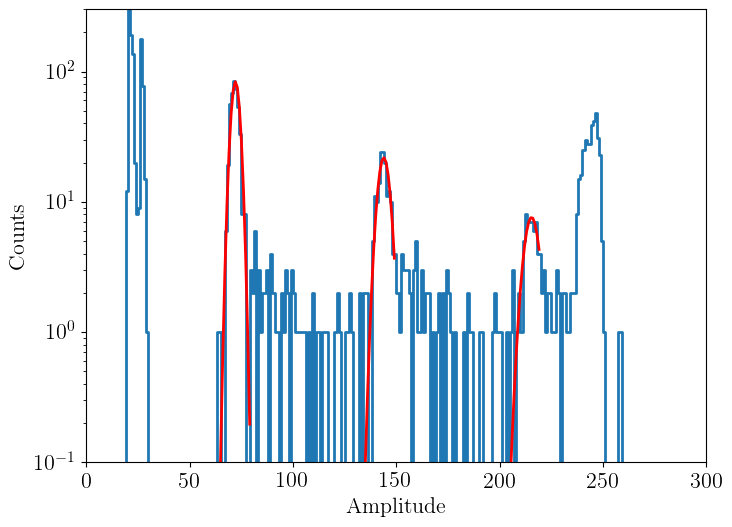

mean_gain 71.79932792758142
sd_gain= 0.24612665459760397


In [36]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height=[]
for vals in D1.peak_height:
    if (vals>0):
        peak_height.append(vals)
    

h,hx = np.histogram(peak_height, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,4):
    cut = np.where((hx[:-1]>pe*i-15) & (hx[:-1]<pe*i+(10)))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print ('pe_fit= ',pe_fit)
gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
gain = np.insert(gain,0,pe_fit[0,1])
print('mean_gain',np.mean(gain))
print('sd_gain=',np.std(gain))

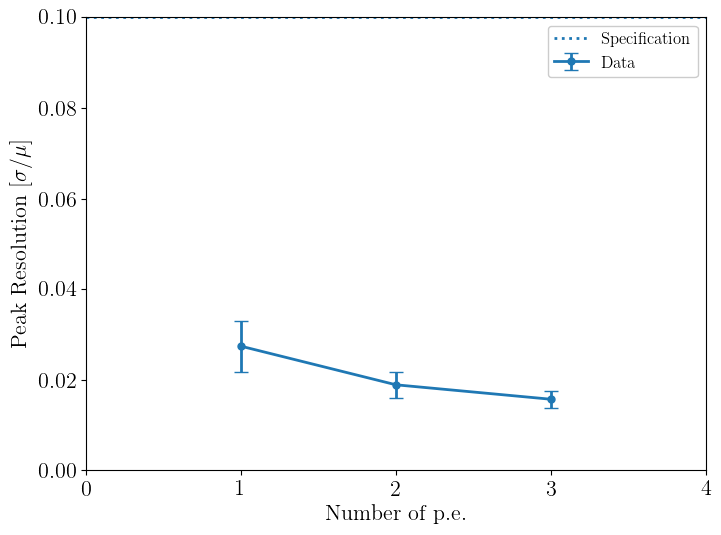

In [37]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()